In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
# read in data
data = "airfoil_self_noise.csv"
# separate by semicolons and get rid of headers
df = pd.read_csv(data, header = None)
# add headers to the columns
df.columns = ["Frequency", "Angle", "Chord", "Velocity", "Displacement", "Decibels"]
# columns are frequency in hertz, angle of attack in degrees, chord length in meters,
# free stream velocity in meters per second, suction side displacement thickness in meters,
# and scaled sound pressure level in decibels
df

,Frequency,Angle,Chord,Velocity,Displacement,Decibels
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461
...,...,...,...,...,...,...
1498,2500,15.6,0.1016,39.6,0.052849,110.264
1499,3150,15.6,0.1016,39.6,0.052849,109.254
1500,4000,15.6,0.1016,39.6,0.052849,106.604
1501,5000,15.6,0.1016,39.6,0.052849,106.224


In [15]:
import numpy as np
# Check for null values
null_values = df.isnull().sum()
print(null_values)  # No null values, no imputation needed
# Function to find and handle outliers using z-score
def find_outliers_z_score(df: pd.DataFrame, column: str) -> pd.DataFrame:
    mean = df[column].mean()
    std_deviation = df[column].std()
    z_scores = (df[column] - mean) / std_deviation
    outliers = df[np.abs(z_scores) > 3]
    # Removing outliers from the DataFrame
    df_no_outliers = df[np.abs(z_scores) <= 3]
    return df_no_outliers
# Select only numerical columns
numerical_df = df.select_dtypes(include=[np.number])
print("-" * 50)
print("Outliers according to Z-score")  # Outliers are points with a z-score greater than 3
for colName in numerical_df.columns:
    print("Column name:", colName)
    print(find_outliers_z_score(df, colName))
    print()
# Store the updated data without outliers into df1
df1 = df.copy()
for colName in numerical_df.columns:
    df1 = find_outliers_z_score(df1, colName)
print("-" * 50)
print("Updated data stored in df1:")
print(df1)


Frequency       0
Angle           0
Chord           0
Velocity        0
Displacement    0
Decibels        0
dtype: int64
--------------------------------------------------
Outliers according to Z-score
Column name: Frequency
      Frequency  Angle   Chord  Velocity  Displacement  Decibels
0           800    0.0  0.3048      71.3      0.002663   126.201
1          1000    0.0  0.3048      71.3      0.002663   125.201
2          1250    0.0  0.3048      71.3      0.002663   125.951
3          1600    0.0  0.3048      71.3      0.002663   127.591
4          2000    0.0  0.3048      71.3      0.002663   127.461
...         ...    ...     ...       ...           ...       ...
1498       2500   15.6  0.1016      39.6      0.052849   110.264
1499       3150   15.6  0.1016      39.6      0.052849   109.254
1500       4000   15.6  0.1016      39.6      0.052849   106.604
1501       5000   15.6  0.1016      39.6      0.052849   106.224
1502       6300   15.6  0.1016      39.6      0.052849   104

In [16]:
from sklearn.preprocessing import StandardScaler
#Split features and target
X = df.drop('Decibels', axis=1)
y = df['Decibels']
# Split into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

X_train shape: torch.Size([1202, 5]), y_train shape: torch.Size([1202, 1])


In [17]:

# 2-Layer Neural Network
class NeuralNet2L(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, activation_fn):
        super(NeuralNet2L, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.activation = activation_fn
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.activation(out)
        out = self.fc2(out)
        return out

# 3-Layer Neural Network
class NeuralNet3L(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, activation_fn):
        super(NeuralNet3L, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.activation = activation_fn
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.activation(out)
        out = self.fc2(out)
        out = self.activation(out)
        out = self.fc3(out)
        return out

# XL Neural Network
class NeuralNetXL(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, activation_fn):
        super(NeuralNetXL, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.activation = activation_fn
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.activation(out)
        out = self.fc2(out)
        out = self.activation(out)
        out = self.fc3(out)
        out = self.activation(out)
        out = self.fc4(out)
        return out


In [18]:
# Define activation functions
activation_functions = {
    'ReLU': nn.ReLU(),
    'Tanh': nn.Tanh(),
    'Sigmoid': nn.Sigmoid(),
    'LeakyReLU': nn.LeakyReLU(),
    'ELU': nn.ELU(),
    'SELU': nn.SELU(),
    'GELU': nn.GELU(),
    'Softplus': nn.Softplus(),
    'Softsign': nn.Softsign()
}
# Define optimizers
optimizer_list = ['SGD', 'Adam', 'RMSprop', 'NAdam']
default_learning_rates = {
    'SGD': 0.0001,
    'Adam': 0.0001,
    'RMSprop': 0.0001,
    'NAdam': 0.0001
}


In [19]:
def get_optimizer_and_scheduler(optimizer_name, model_parameters):
    lr = default_learning_rates[optimizer_name]
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(model_parameters, lr=lr, momentum=0.9)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(model_parameters, lr=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(model_parameters, lr=lr)
    elif optimizer_name == 'NAdam':
        optimizer = optim.NAdam(model_parameters, lr=lr)
    else:
        raise ValueError(f"Optimizer {optimizer_name} not recognized.")
    # Define a scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
    return optimizer, scheduler


In [20]:
from sklearn.metrics import mean_squared_error, r2_score
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
# Define the loss function
criterion = nn.MSELoss()
def check_for_nans(tensor, tensor_name):
    has_nan = torch.isnan(tensor).any()
    has_inf = torch.isinf(tensor).any()
    print(f"{tensor_name} contains NaN: {has_nan}, contains Inf: {has_inf}")
check_for_nans(X_train, "X_train")
check_for_nans(y_train, "y_train")
check_for_nans(X_test, "X_test")
check_for_nans(y_test, "y_test")


X_train contains NaN: False, contains Inf: False
y_train contains NaN: False, contains Inf: False
X_test contains NaN: False, contains Inf: False
y_test contains NaN: False, contains Inf: False


In [21]:

def train_model(model, criterion, optimizer, scheduler, train_loader, num_epochs=100):
            model.train()
            for epoch in range(num_epochs):
                epoch_loss = 0.0
                for inputs, targets in train_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)

                    if torch.isnan(loss):
                        print(f"NaN loss encountered at epoch {epoch+1}")
                        return model

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    epoch_loss += loss.item()

                scheduler.step()
                avg_loss = epoch_loss / len(train_loader)
                if (epoch+1)==100:
                    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}")
            return model


In [22]:
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test) 
        # Convert tensors to numpy arrays
        y_pred = predictions.cpu().numpy()
        y_true = y_test.cpu().numpy()
        # Check for NaNs in predictions and true labels
        if np.isnan(y_pred).any():
            print("NaNs detected in model predictions.")
            return np.nan, np.nan, np.nan, np.nan, None, None
        if np.isnan(y_true).any():
            print("NaNs detected in true labels.")
            return np.nan, np.nan, np.nan, np.nan, None, None
        # Calculate metrics
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true, y_pred)
        sse = np.sum((y_true - y_pred) ** 2)
    
    return mse, rmse, r2, sse, y_true, y_pred  # Return y_true and y_pred for plotting


In [23]:
from sklearn.model_selection import KFold

# Define 5-fold cross-validation with shuffling and a fixed random state for reproducibility
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Helper function to evaluate the model with 5-fold cross-validation
def cross_val_evaluate(model, X, y, criterion, optimizer_name, activation_name):
    mse_scores = []   # To store MSE for each fold
    rmse_scores = []  # To store RMSE for each fold
    r2_scores = []    # To store R² for each fold
    y_true_all = []   # To store true values across folds for plotting
    y_pred_all = []   # To store predicted values across folds for plotting
    print("5-fold cross-validation evaluation")

    # Loop through each folda
    for train_index, val_index in kf.split(X):
        # Split the data into training and validation sets for the current fold
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]
        
        # Initialize model, optimizer, and scheduler for the fold
        model_fold = model  # Re-initialize model for each fold
        optimizer, scheduler = get_optimizer_and_scheduler(optimizer_name, model_fold.parameters())

        # Train the model on the current fold
        model_fold = train_model(model_fold, criterion, optimizer, scheduler, train_loader, num_epochs=100)
        
        # Evaluate the model on the validation fold
        mse, rmse, r2, _, y_true_fold, y_pred_fold = evaluate_model(model_fold, X_val_fold, y_val_fold)
        mse_scores.append(mse)  # Save MSE for this fold
        rmse_scores.append(rmse)  # Save RMSE for this fold
        r2_scores.append(r2)  # Save R² for this fold
        
        # Append true and predicted values for each fold for plotting
        y_true_all.extend(y_true_fold)
        y_pred_all.extend(y_pred_fold)
    
    # Calculate average metrics across all folds
    avg_mse = np.mean(mse_scores)
    avg_rmse = np.mean(rmse_scores)
    avg_r2 = np.mean(r2_scores)
    
    return avg_mse, avg_rmse, avg_r2, np.array(y_true_all), np.array(y_pred_all)  # Return average metrics and all true/predicted values


In [24]:
import numpy as np
num_epochs = 100  
model_metrics = {}

for activation_name, activation_fn in activation_functions.items():
    for optimizer_name in optimizer_list:
        print(f"Testing Activation: {activation_name}, Optimizer: {optimizer_name}")
        input_size_2L = 5     # Based on 5 features
        hidden_size_2L = 256    # Larger hidden layer
        output_size_2L = 1     # Predicting a single value (Decibels)
        # 3-Layer Neural Network (moderate complexity)a
        input_size_3L = 5   # Same input size
        hidden_size_3L = 256  # Larger hidden layer
        output_size_3L = 1     # Predicting a single value (Decibels)
        # XL Model (complex model with more layers or larger hidden size)
        input_size_XL = 5      # Same input size
        hidden_size_XL = 256   # Even larger hidden layer
        output_size_XL = 1     # Predicting a single value (Decibels)
        # Define model configurations
        model_2L = NeuralNet2L(input_size_2L, hidden_size_2L, output_size_2L, activation_fn)
        model_3L = NeuralNet3L(input_size_3L, hidden_size_3L, output_size_3L, activation_fn)
        model_XL = NeuralNetXL(input_size_XL, hidden_size_XL, output_size_XL, activation_fn)       
        # Get optimizer and scheduler for each model
        optimizer_2L, scheduler_2L = get_optimizer_and_scheduler(optimizer_name, model_2L.parameters())
        optimizer_3L, scheduler_3L = get_optimizer_and_scheduler(optimizer_name, model_3L.parameters())
        optimizer_XL, scheduler_XL = get_optimizer_and_scheduler(optimizer_name, model_XL.parameters())        
        # Train models
        print("training 2L net")
        model_2L = train_model(model_2L, criterion, optimizer_2L, scheduler_2L, train_loader)
        print("training 3l net")
        model_3L = train_model(model_3L, criterion, optimizer_3L, scheduler_3L, train_loader)
        print("training Xl net")
        model_XL = train_model(model_XL, criterion, optimizer_XL, scheduler_XL, train_loader)        
        # Evaluate models
        print("starting evaluation")
        train_mse_2L, train_rmse_2L, train_r2_2L, train_sse_2L, y_true_train_2L, y_pred_train_2L = evaluate_model(model_2L, X_train, y_train)
        test_mse_2L, test_rmse_2L, test_r2_2L, test_sse_2L, y_true_test_2L, y_pred_test_2L = evaluate_model(model_2L, X_test, y_test)        
        train_mse_3L, train_rmse_3L, train_r2_3L, train_sse_3L, y_true_train_3L, y_pred_train_3L = evaluate_model(model_3L, X_train, y_train)
        test_mse_3L, test_rmse_3L, test_r2_3L, test_sse_3L, y_true_test_3L, y_pred_test_3L = evaluate_model(model_3L, X_test, y_test)       
        train_mse_XL, train_rmse_XL, train_r2_XL, train_sse_XL, y_true_train_XL, y_pred_train_XL = evaluate_model(model_XL, X_train, y_train)
        test_mse_XL, test_rmse_XL, test_r2_XL, test_sse_XL, y_true_test_XL, y_pred_test_XL = evaluate_model(model_XL, X_test, y_test)
        # Cross-validation results
        cv_mse_2L, cv_rmse_2L, cv_r2_2L,y_true_cv_2L,y_true_train_cv_2L = cross_val_evaluate(model_2L, X_train, y_train, criterion, optimizer_name, activation_name)
        cv_mse_3L, cv_rmse_3L, cv_r2_3L,y_true_cv_3L,y_true_train_cv_3L = cross_val_evaluate(model_3L, X_train, y_train, criterion, optimizer_name, activation_name)
        cv_mse_XL, cv_rmse_XL, cv_r2_XL,y_true_cv_XL,y_true_train_cv_XL = cross_val_evaluate(model_XL, X_train, y_train, criterion, optimizer_name, activation_name)
        # Store metrics and predictions in model_metrics
        key = f'Activation: {activation_name}, Optimizer: {optimizer_name}'
        model_metrics[key] = {
            '2-Layer Neural Network': {
                'In-Sample MSE': train_mse_2L, 'In-Sample RMSE': train_rmse_2L, 'In-Sample R²': train_r2_2L,
                'Validation MSE': test_mse_2L, 'Validation RMSE': test_rmse_2L, 'Validation R²': test_r2_2L,
                'Cross-Validation MSE': cv_mse_2L, 'Cross-Validation RMSE': cv_rmse_2L, 'Cross-Validation R²': cv_r2_2L,
                'y_true_train': y_true_train_2L, 'y_pred_train': y_pred_train_2L,
                'y_true_test': y_true_test_2L, 'y_pred_test': y_pred_test_2L
            },
            '3-Layer Neural Network': {
                'In-Sample MSE': train_mse_3L, 'In-Sample RMSE': train_rmse_3L, 'In-Sample R²': train_r2_3L,
                'Validation MSE': test_mse_3L, 'Validation RMSE': test_rmse_3L, 'Validation R²': test_r2_3L,
                'Cross-Validation MSE': cv_mse_3L, 'Cross-Validation RMSE': cv_rmse_3L, 'Cross-Validation R²': cv_r2_3L,
                'y_true_train': y_true_train_3L, 'y_pred_train': y_pred_train_3L,
                'y_true_test': y_true_test_3L, 'y_pred_test': y_pred_test_3L
            },
            'XL Neural Network': {
                'In-Sample MSE': train_mse_XL, 'In-Sample RMSE': train_rmse_XL, 'In-Sample R²': train_r2_XL,
                'Validation MSE': test_mse_XL, 'Validation RMSE': test_rmse_XL, 'Validation R²': test_r2_XL,
                'Cross-Validation MSE': cv_mse_XL, 'Cross-Validation RMSE': cv_rmse_XL, 'Cross-Validation R²': cv_r2_XL,
                'y_true_train': y_true_train_XL, 'y_pred_train': y_pred_train_XL,
                'y_true_test': y_true_test_XL, 'y_pred_test': y_pred_test_XL
            }
        }


Testing Activation: ReLU, Optimizer: SGD
training 2L net
Epoch [100/100], Loss: 20.845363
training 3l net
Epoch [100/100], Loss: 11.666045
training Xl net
Epoch [100/100], Loss: 9.340922
starting evaluation
5-fold cross-validation evaluation
Epoch [100/100], Loss: 18.303214
Epoch [100/100], Loss: 17.975233
Epoch [100/100], Loss: 16.523029
Epoch [100/100], Loss: 15.631358
Epoch [100/100], Loss: 14.948725
5-fold cross-validation evaluation
Epoch [100/100], Loss: 8.531790
Epoch [100/100], Loss: 7.000087
Epoch [100/100], Loss: 6.094772
Epoch [100/100], Loss: 5.181322
Epoch [100/100], Loss: 4.520917
5-fold cross-validation evaluation
Epoch [100/100], Loss: 6.528399
Epoch [100/100], Loss: 5.237841
Epoch [100/100], Loss: 3.957223
Epoch [100/100], Loss: 3.217600
Epoch [100/100], Loss: 2.720897
Testing Activation: ReLU, Optimizer: Adam
training 2L net
Epoch [100/100], Loss: 14493.916016
training 3l net
Epoch [100/100], Loss: 2432.680981
training Xl net
Epoch [100/100], Loss: 369.582034
starting

In [25]:
print("\nModel Performance Comparison:")
for model_name, metrics in model_metrics.items():
    print(f"\n{model_name}:")
    for metric_name, metric_value in metrics.items():
        # Skip specific metrics by name                          
        if metric_name in ['y_true', 'y_pred_test']:
            continue
        if isinstance(metric_value, dict):
            print(f"  {metric_name}:")
            for sub_metric_name, sub_metric_value in metric_value.items():
                # Skip specific sub-metrics by name
                if sub_metric_name in ['y_true_train', 'y_pred_test','y_true_test','y_pred_train']:
                    continue
                if isinstance(sub_metric_value, float):
                    print(f"    {sub_metric_name}: {sub_metric_value:.4f}")
                else:
                    print(f"    {sub_metric_name}: {sub_metric_value}")
        elif isinstance(metric_value, float):
            print(f"  {metric_name}: {metric_value:.4f}")
        else:
            print(f"  {metric_name}: {metric_value}")



Model Performance Comparison:

Activation: ReLU, Optimizer: SGD:
  2-Layer Neural Network:
    In-Sample MSE: 20.792686462402344
    In-Sample RMSE: 4.559899806976318
    In-Sample R²: 0.5568
    Validation MSE: 19.5152645111084
    Validation RMSE: 4.417608261108398
    Validation R²: 0.6105
    Cross-Validation MSE: 16.687406539916992
    Cross-Validation RMSE: 4.052008628845215
    Cross-Validation R²: 0.6437
  3-Layer Neural Network:
    In-Sample MSE: 11.668798446655273
    In-Sample RMSE: 3.4159622192382812
    In-Sample R²: 0.7513
    Validation MSE: 11.992977142333984
    Validation RMSE: 3.463087797164917
    Validation R²: 0.7606
    Cross-Validation MSE: 6.4855217933654785
    Cross-Validation RMSE: 2.5006473064422607
    Cross-Validation R²: 0.8630
  XL Neural Network:
    In-Sample MSE: 9.489813804626465
    In-Sample RMSE: 3.080554246902466
    In-Sample R²: 0.7977
    Validation MSE: 10.123703956604004
    Validation RMSE: 3.181776762008667
    Validation R²: 0.7979
   

In [29]:
# Initialize a dictionary to store the best performance and details for each network type
best_performance = {
    '2-Layer Neural Network': {'R²': -float('inf'), 'Details': None},
    '3-Layer Neural Network': {'R²': -float('inf'), 'Details': None},
    'XL Neural Network': {'R²': -float('inf'), 'Details': None}
}
                
# Iterate through each configuration and model to find the best R² based on all metrics
for config, model_data in model_metrics.items():
    for model_name, metrics in model_data.items():
        # Extract the three R² metrics
        validation_r2 = metrics.get('Validation R²', -float('inf'))
        insample_r2 = metrics.get('In-Sample R²', -float('inf'))
        cross_val_r2 = metrics.get('Cross-Validation R²', -float('inf'))
        
        # Find the highest R² among the three for the current configuration
        best_r2 = max(validation_r2, insample_r2, cross_val_r2)
        
        # Check if this is the best R² score for the current model type
        if best_r2 > best_performance[model_name]['R²']:
            best_performance[model_name]['R²'] = best_r2
            best_performance[model_name]['Details'] = {
                'Activation and Optimizer': config,
                'Best Metric': 'Validation R²' if best_r2 == validation_r2 else 'In-Sample R²' if best_r2 == insample_r2 else 'Cross-Validation R²',
                'Metrics': metrics
            }

# Print the best performance for each network type
print("\nBest Performance for Each Neural Network Layer:")
for model_name, performance in best_performance.items():
    print(f"\n{model_name}:")
    print(f"  Best R²: {performance['R²']:.4f}")
    print(f"  Best Metric: {performance['Details']['Best Metric']}")
    print(f"  Activation and Optimizer: {performance['Details']['Activation and Optimizer']}")
    print("  Metrics:")
    for metric_name, metric_value in performance['Details']['Metrics'].items():

        if isinstance(metric_value, dict):
            print(f"    {metric_name}:")
            for sub_metric_name, sub_metric_value in metric_value.items():
                # Skip specific sub-metrics by name
                if sub_metric_name in ['y_true_train', 'y_pred_test', 'y_true_test', 'y_pred_train']:
                    continue
                if isinstance(sub_metric_value, float):
                    print(f"      {sub_metric_name}: {sub_metric_value:.4f}")
                else:
                    print(f"      {sub_metric_name}: {sub_metric_value}")
        elif isinstance(metric_value, float):
            print(f"    {metric_name}: {metric_value:.4f}")
        else:
            print(f"    {metric_name}: {metric_value}")



Best Performance for Each Neural Network Layer:

2-Layer Neural Network:
  Best R²: 0.6960
  Best Metric: Cross-Validation R²
  Activation and Optimizer: Activation: SELU, Optimizer: SGD
  Metrics:
    In-Sample MSE: 18.644153594970703
    In-Sample RMSE: 4.317887783050537
    In-Sample R²: 0.6026
    Validation MSE: 17.83548927307129
    Validation RMSE: 4.223208427429199
    Validation R²: 0.6440
    Cross-Validation MSE: 14.292463302612305
    Cross-Validation RMSE: 3.7420883178710938
    Cross-Validation R²: 0.6960
    y_true_train: [[129.946]
 [134.568]
 [136.414]
 ...
 [133.13 ]
 [124.717]
 [128.978]]
    y_pred_train: [[130.06322 ]
 [130.0927  ]
 [126.49512 ]
 ...
 [128.64104 ]
 [121.18746 ]
 [124.630356]]
    y_true_test: [[125.045]
 [118.767]
 [120.233]
 [137.047]
 [134.556]
 [120.766]
 [124.525]
 [136.798]
 [130.123]
 [123.991]
 [126.78 ]
 [110.652]
 [134.528]
 [133.756]
 [123.354]
 [107.985]
 [125.581]
 [130.558]
 [128.956]
 [121.582]
 [125.343]
 [128.74 ]
 [109.949]
 [126.

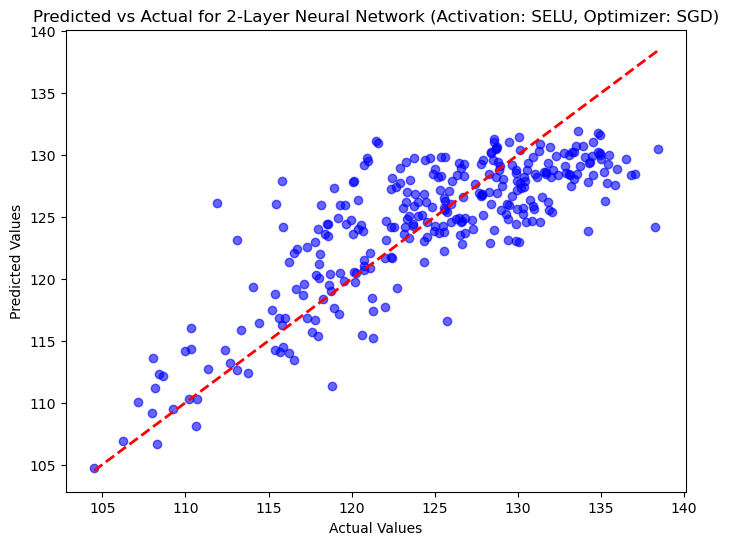

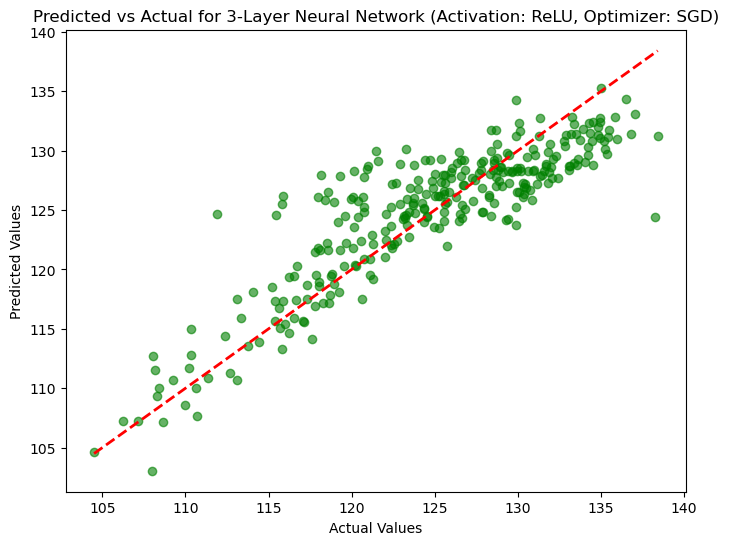

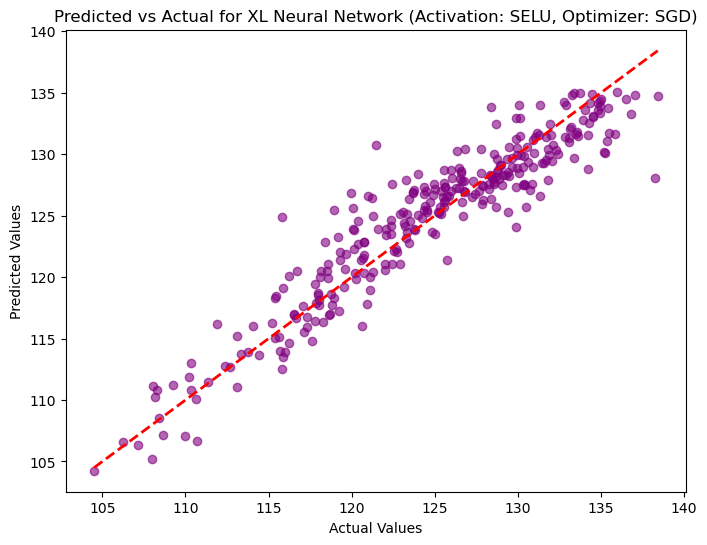

In [32]:
import matplotlib.pyplot as plt

# Function to plot predicted vs actual values with specified color
def plot_predicted_vs_actual(y_true, y_pred, title, color):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.6, color=color)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Predicted vs Actual for {title}")
    plt.show()

# Define colors for each model type
model_colors = {
    '2-Layer Neural Network': 'blue',
    '3-Layer Neural Network': 'green',
    'XL Neural Network': 'purple'
}

# Plot for each best-performing model configuration
for model_name, performance in best_performance.items():
    # Retrieve the best activation and optimizer configuration
    config = performance['Details']['Activation and Optimizer']
    # Retrieve y_true_test and y_pred_test from the best configuration
    y_true_test = performance['Details']['Metrics'].get('y_true_test')
    y_pred_test = performance['Details']['Metrics'].get('y_pred_test')
    
    # Plot predicted vs actual if y_true_test and y_pred_test are present
    if y_true_test is not None and y_pred_test is not None:
        plot_predicted_vs_actual(y_true_test, y_pred_test, f"{model_name} ({config})", model_colors[model_name])


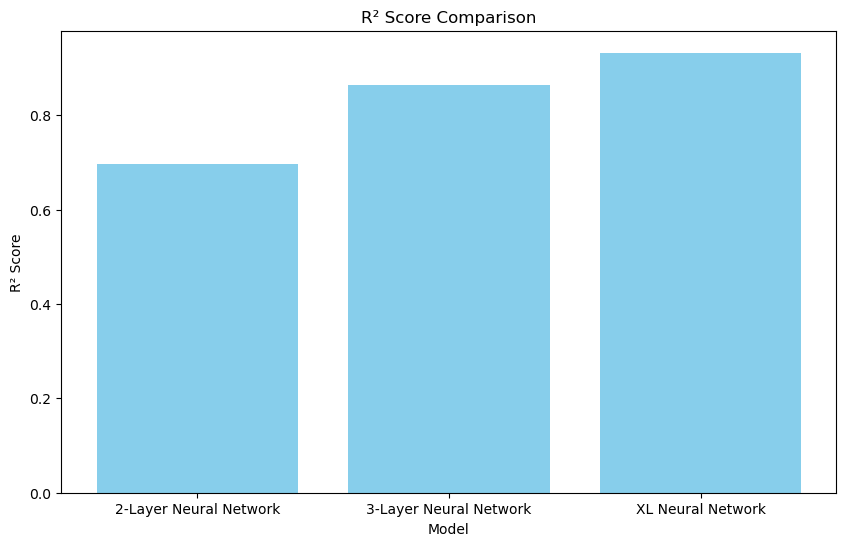

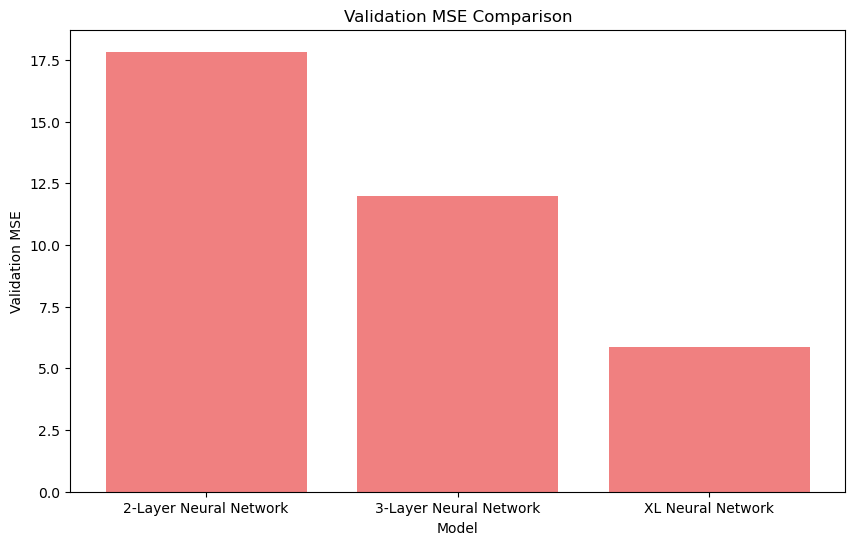

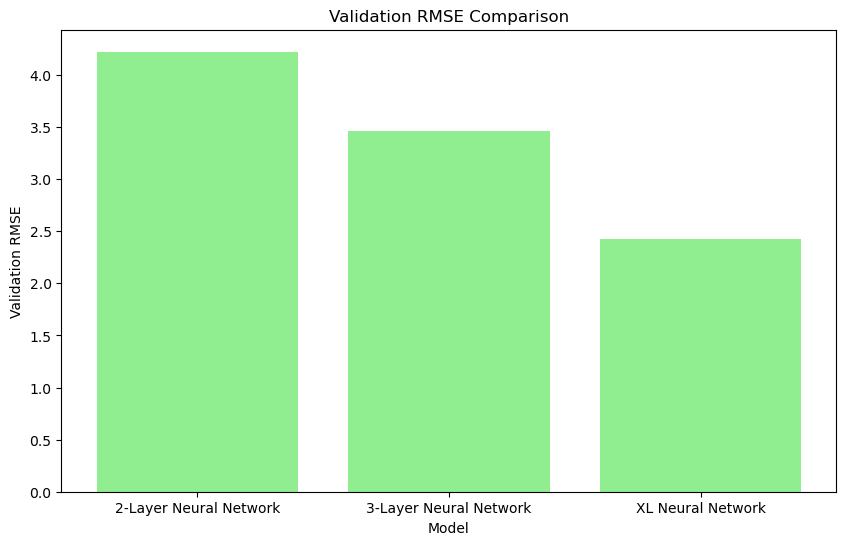

In [31]:
def plot_performance_metrics(best_performance):
    # Collect metrics for plotting
    models = list(best_performance.keys())
    r2_scores = [best_performance[model]['R²'] for model in models]
    mse_scores = [best_performance[model]['Details']['Metrics']['Validation MSE'] for model in models]
    rmse_scores = [best_performance[model]['Details']['Metrics']['Validation RMSE'] for model in models]
    # Plot R² Scores
    plt.figure(figsize=(10, 6))
    plt.bar(models, r2_scores, color='skyblue')
    plt.xlabel("Model")
    plt.ylabel("R² Score")
    plt.title("R² Score Comparison")
    plt.show()
    # Plot MSE Scores
    plt.figure(figsize=(10, 6))
    plt.bar(models, mse_scores, color='lightcoral')
    plt.xlabel("Model")
    plt.ylabel("Validation MSE")
    plt.title("Validation MSE Comparison")
    plt.show()
    # Plot RMSE Scores
    plt.figure(figsize=(10, 6))
    plt.bar(models, rmse_scores, color='lightgreen')
    plt.xlabel("Model")
    plt.ylabel("Validation RMSE")
    plt.title("Validation RMSE Comparison")
    plt.show()
plot_performance_metrics(best_performance)


In [33]:
import torch
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
# Initialize the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
# Train the model
rf_model.fit(X_train.numpy(), y_train.numpy().ravel())
# Make predictions on the test set
rf_predictions = rf_model.predict(X_test.numpy())
# Evaluate the model
rf_mse = mean_squared_error(y_test.numpy(), rf_predictions)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_test.numpy(), rf_predictions)
# Display the evaluation metrics
print(f'Random Forest Test MSE : {rf_mse:.4f}')
print(f'Random Forest Test RMSE: {rf_rmse:.4f}')
print(f'Random Forest Test R²   : {rf_r2:.4f}')


Random Forest Test MSE : 3.2960
Random Forest Test RMSE: 1.8155
Random Forest Test R²   : 0.9342


In [34]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_grid = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2
)
rf_grid.fit(X_train.numpy(), y_train.numpy().ravel())
print(f'Best Parameters: {rf_grid.best_params_}')
print(f'Best CV MSE: {rf_grid.best_score_:.4f}')
# Evaluate on Test Set
best_rf = rf_grid.best_estimator_
rf_test_predictions = best_rf.predict(X_test.numpy())
rf_test_mse = mean_squared_error(y_test.numpy(), rf_test_predictions)
rf_r2 = r2_score(y_test.numpy(), rf_test_predictions)
print(f'Best Random Forest Test MSE: {rf_test_mse:.4f}')
print(f'Best Random Forest Test R2: {rf_r2:.4f}')


Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END m

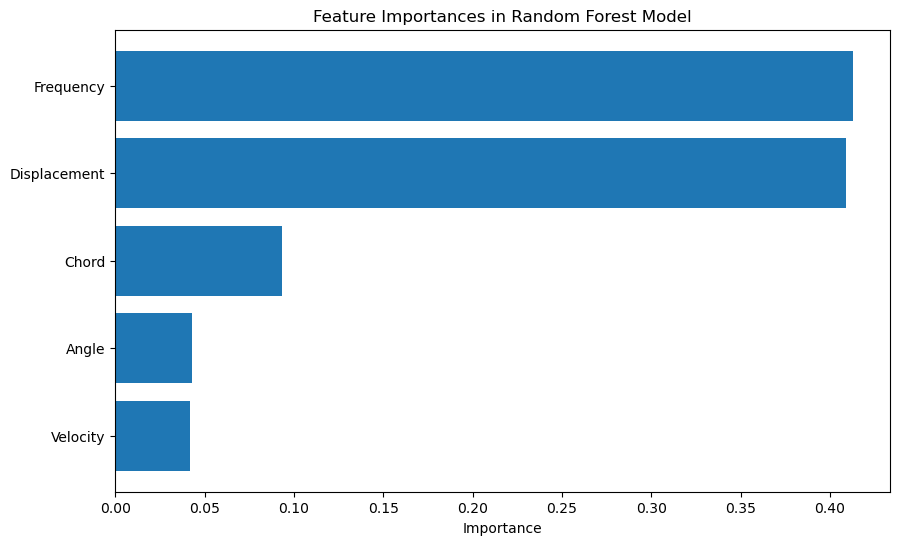

In [35]:
import matplotlib.pyplot as plt
import pandas as pd
# Extract feature importances from the best Random Forest model
feature_importances = best_rf.feature_importances_
feature_names = X.columns
# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)
# Plot feature importances
plt.figure(figsize=(10,6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances in Random Forest Model')
plt.gca().invert_yaxis()  
plt.show()


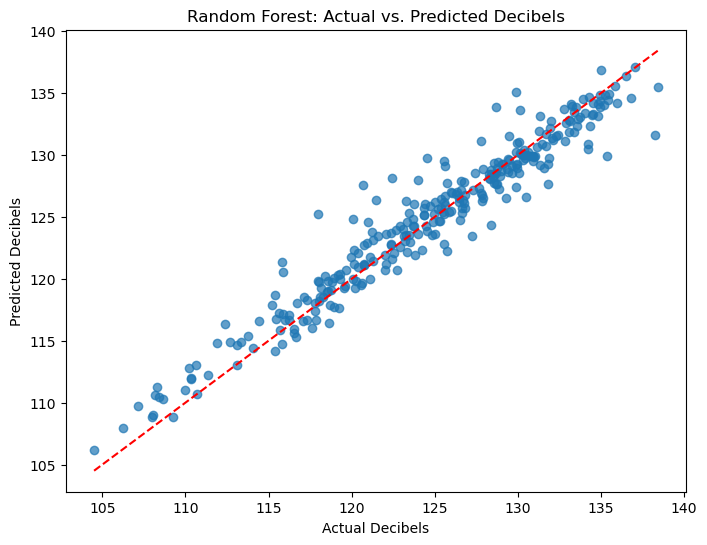

In [35]:
# Scatter plot for Random Forest predictions
plt.figure(figsize=(8,6))
plt.scatter(y_test.numpy(), rf_test_predictions, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
plt.xlabel('Actual Decibels')
plt.ylabel('Predicted Decibels')
plt.title('Random Forest: Actual vs. Predicted Decibels')
plt.show()


In [37]:
from sklearn.model_selection import cross_val_score
# Calculate cross-validated R² scores
cv_r2_scores = cross_val_score(best_rf, X_train.numpy(), y_train.numpy().ravel(), cv=5, scoring='r2')
print(f'\nCross-Validated R² Scores: {cv_r2_scores}')
print(f'Average Cross-Validated R² Score: {cv_r2_scores.mean():.4f}')


Cross-Validated R² Scores: [0.93686281 0.92761618 0.91976964 0.92730733 0.90115417]
Average Cross-Validated R² Score: 0.9225
